# Identifying dog breeds

DS 4002


## Preprocessing Data

In [ ]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

%tensorflow_version 2.x
import tensorflow as tf
from tensorflow import keras

np.random.seed(42)
tf.random.set_seed(42)

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.


In [ ]:
# Install PyDrive
!pip install PyDrive

#Import modules
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#Get the Shareable link
#Ex link : https://drive.google.com/file/d/1c7Ffo1Go1dtUpKcSWxdbdVyW4dfhEoUp/view?usp=sharing
downloaded = drive.CreateFile({'id':"1D4xfomtYDiKLmW0_xpYPrX4EvnknuB3x"})
downloaded.GetContentFile('dog_reduced.zip')

In [ ]:
!unzip dog_reduced.zip


Archive:  dog_reduced.zip
   creating: Dog_reduced/
   creating: Dog_reduced/images_reduced/
   creating: Dog_reduced/images_reduced/n02085936-Maltese_dog/
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10073.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10130.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10273.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10377.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10397.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_10661.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_1155.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_11653.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_1247.jpg  
  inflating: Dog_reduced/images_reduced/n02085936-Maltese_dog/n02085936_126.jpg  
  inflat

In [ ]:
from sklearn.datasets import load_files

from keras.preprocessing import image
from tqdm import tqdm # progress bar

train_data_dir = "/content/Dog_reduced/images_reduced/"
test_data_dir = "/content/test/"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 64;
img_width = 64;

# Training Dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_data_dir,
    labels='inferred',
    # label_mode="categorical",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# # Testing Dataset
# test_ds = tf.keras.preprocessing.image_dataset_from_directory(
#     test_data_dir,
#     labels='inferred',
#     # label_mode="categorical",
#     seed = 42,
#     image_size= (img_height, img_width),
#     batch_size = batch_size
# )

print("Training Classes:")
train_ds_class_names = dataset.class_names
print(train_ds_class_names)


Found 2233 files belonging to 10 classes.
Training Classes:
['n02085936-Maltese_dog', 'n02086240-Shih-Tzu', 'n02088094-Afghan_hound', 'n02090721-Irish_wolfhound', 'n02092002-Scottish_deerhound', 'n02107683-Bernese_mountain_dog', 'n02111129-Leonberg', 'n02111500-Great_Pyrenees', 'n02111889-Samoyed', 'n02112018-Pomeranian']


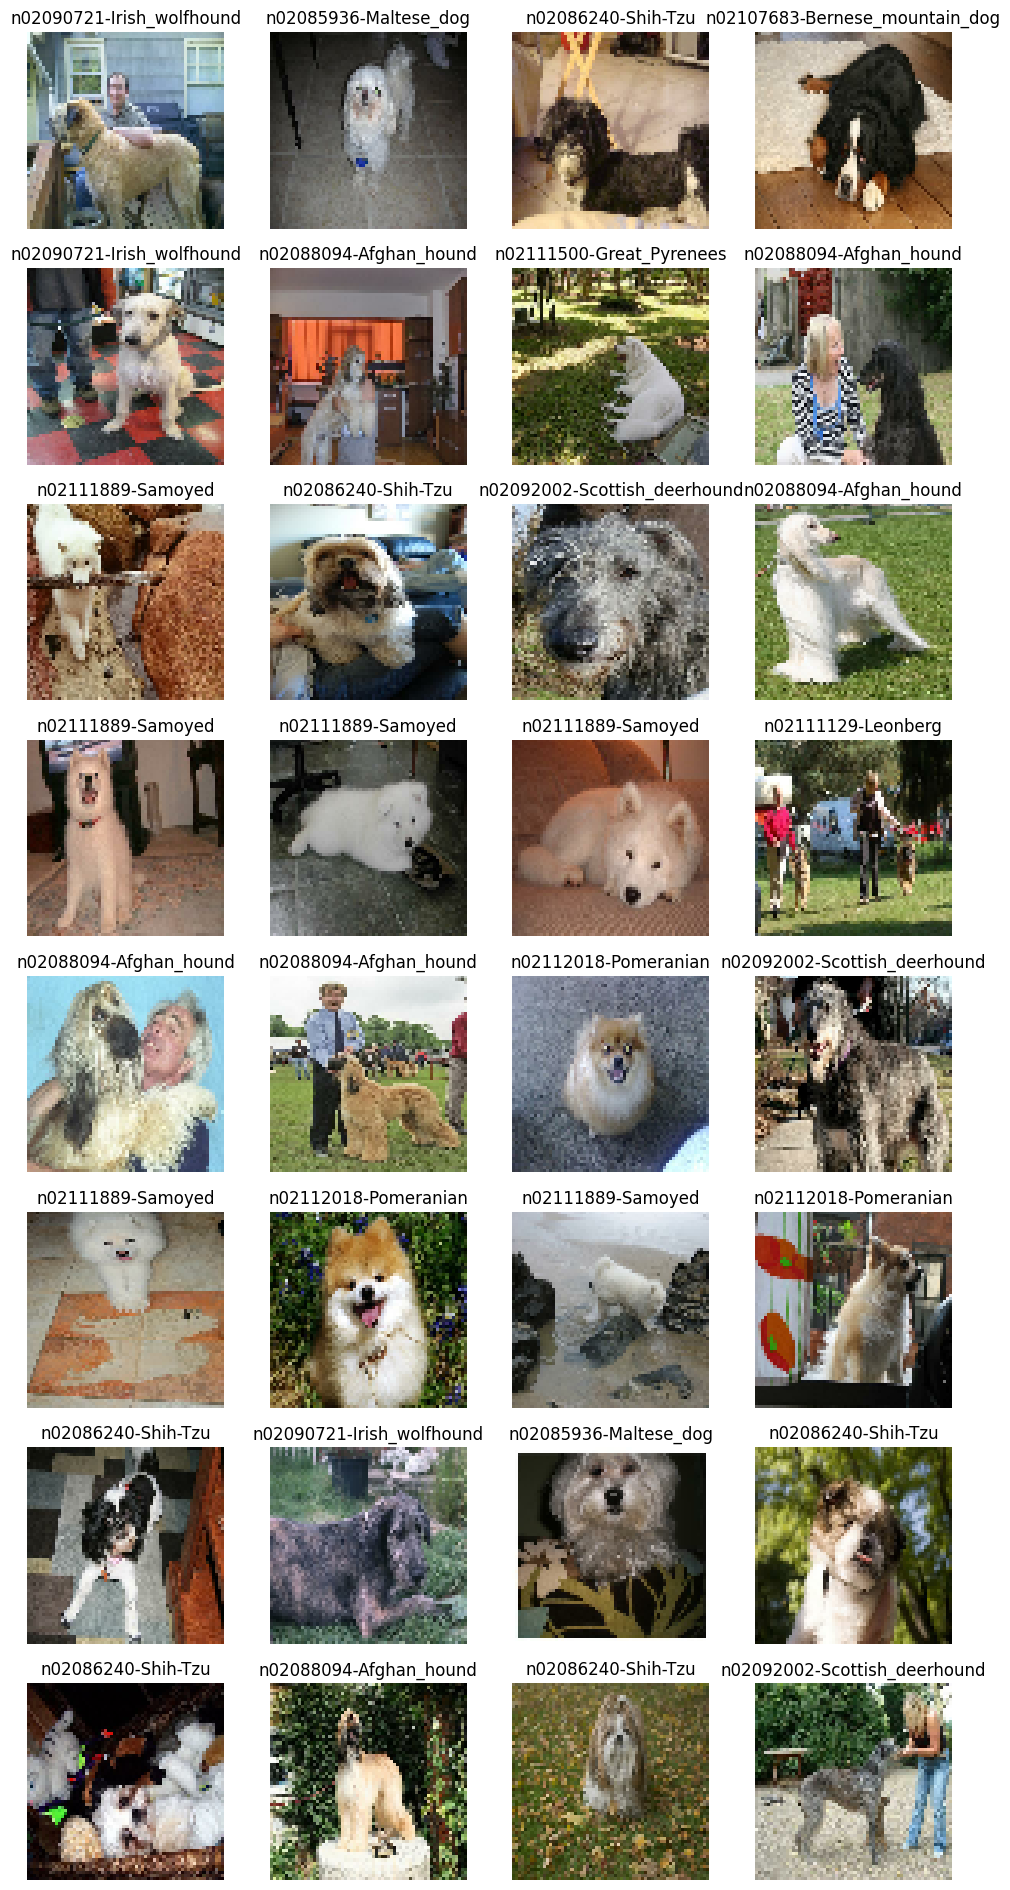

In [ ]:
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in dataset.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(train_ds_class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)


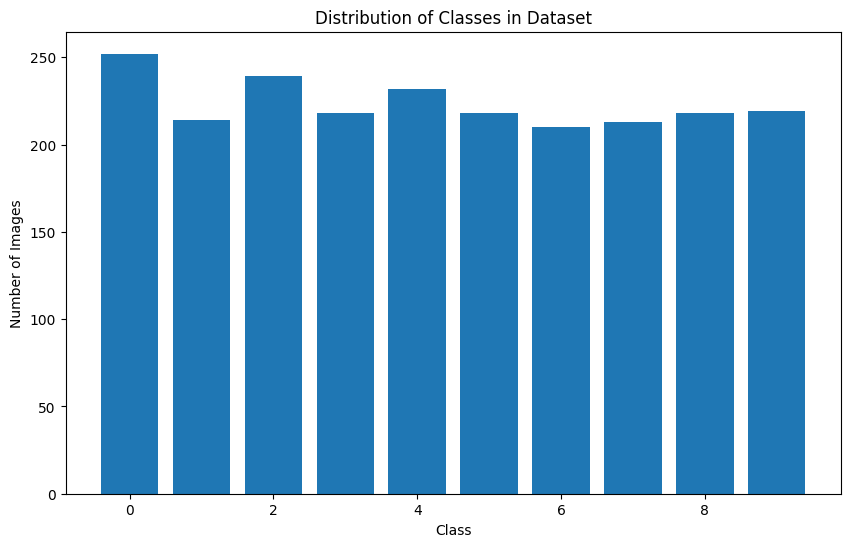

In [ ]:
import matplotlib.pyplot as plt

# Count the number of images in each class
class_counts = [0] * len(dataset.class_names)
for images, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1

# Plot the histogram
plt.figure(figsize=(10, 6))
plt.bar(range(len(class_counts)), class_counts)
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.title('Distribution of Classes in Dataset')
plt.show()


In [ ]:
# Determine the size of the train and test sets
size = len(dataset)
train_size = int(0.8 * size)
test_size = size - train_size

# Split the dataset into train and test sets
train_dataset = dataset.take(train_size)
test_dataset = dataset.skip(train_size)



## Convolutional Neural Network (CNN)


In [ ]:
from functools import partial

DefaultConv2D = partial(keras.layers.Conv2D, kernel_size=3, activation='relu', padding="SAME")

myModel = keras.models.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(7, 7), input_shape=(img_width, img_height, 3), activation='relu', padding="same"),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    keras.layers.MaxPooling2D(pool_size=2),
    DefaultConv2D(filters=512),
    DefaultConv2D(filters=512),
    keras.layers.MaxPooling2D(pool_size=2),
    keras.layers.Dense(units=256, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(units=64, activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Flatten(),
    keras.layers.Dense(120, activation="softmax")
])
myModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        9472      
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 128)       73856     
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 128)       0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)       2

In [ ]:
myOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
myLoss = 'sparse_categorical_crossentropy'
myMetrics = ['accuracy']
myModel.compile(loss= myLoss, optimizer = myOptimizer, metrics = myMetrics)

history = myModel.fit(train_dataset, validation_data=test_dataset, epochs = 30)

Epoch 1/10
56/56 [==============================] - 17s 93ms/step - loss: 3.5693 - accuracy: 0.0831 - val_loss: 2.5357 - val_accuracy: 0.1066
Epoch 2/10
56/56 [==============================] - 4s 75ms/step - loss: 2.4683 - accuracy: 0.0898 - val_loss: 2.3763 - val_accuracy: 0.0975
Epoch 3/10
56/56 [==============================] - 4s 75ms/step - loss: 2.3878 - accuracy: 0.1105 - val_loss: 2.3347 - val_accuracy: 0.1043
Epoch 4/10
56/56 [==============================] - 5s 95ms/step - loss: 2.3725 - accuracy: 0.0954 - val_loss: 2.3093 - val_accuracy: 0.1293
Epoch 5/10
56/56 [==============================] - 4s 73ms/step - loss: 2.3443 - accuracy: 0.1200 - val_loss: 2.2880 - val_accuracy: 0.1429
Epoch 6/10
56/56 [==============================] - 5s 87ms/step - loss: 2.3265 - accuracy: 0.1295 - val_loss: 2.2917 - val_accuracy: 0.1134
Epoch 7/10
56/56 [==============================] - 5s 85ms/step - loss: 2.2963 - accuracy: 0.1417 - val_loss: 2.2301 - val_accuracy: 0.1474
Epoch 8/10
5

## Transfer Learning

In [ ]:
# Your code here
base_model = keras.applications.EfficientNetV2B1(weights="imagenet",
                                                  include_top=False)
avg = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(120, activation="softmax")(avg)
model = keras.models.Model(inputs=base_model.input, outputs=output)

28456008/28456008 [==============================] - 2s 0us/step


In [ ]:
# Phase 1 code here
for layer in base_model.layers:
    layer.trainable = True

myOptimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=myOptimizer,
              metrics=["accuracy"])
history = model.fit(train_dataset,
                    validation_data=test_dataset,
                    epochs=5)





Epoch 1/5
56/56 [==============================] - 105s 256ms/step - loss: 2.5653 - accuracy: 0.3516 - val_loss: 1.0704 - val_accuracy: 0.6395
Epoch 2/5
56/56 [==============================] - 10s 176ms/step - loss: 0.9703 - accuracy: 0.6663 - val_loss: 0.8165 - val_accuracy: 0.7460
Epoch 3/5
56/56 [==============================] - 9s 162ms/step - loss: 0.5531 - accuracy: 0.8142 - val_loss: 0.8657 - val_accuracy: 0.7460
Epoch 4/5
56/56 [==============================] - 10s 182ms/step - loss: 0.3574 - accuracy: 0.8756 - val_loss: 0.8172 - val_accuracy: 0.7778
Epoch 5/5
56/56 [==============================] - 9s 154ms/step - loss: 0.3231 - accuracy: 0.8951 - val_loss: 0.9702 - val_accuracy: 0.7483


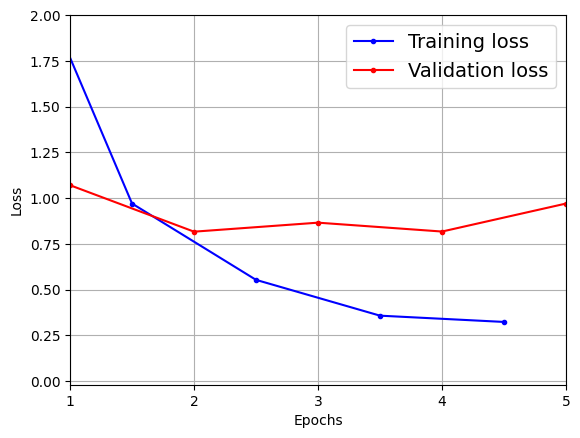

In [ ]:
def plot_learning_curves(loss, val_loss, epochs):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, epochs, -0.02, 2])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"], 5)

In [ ]:
y_true = []
y_pred = []
missclassified = []

for x_batch, y_batch in test_dataset:
    batch_predictions = model.predict(x_batch)
    batch_predictions = np.argmax(batch_predictions, axis=-1)
    y_pred.extend(batch_predictions)
    y_true.extend(y_batch)
    for i in range(len(y_batch)):
      if batch_predictions[i] != y_batch[i]:
        missclassified.append((x_batch[i], y_batch[i]))


y_true = np.array(y_true)
y_pred = np.array(y_pred)

cf_matrix = confusion_matrix(y_true, y_pred)

print("Confusion Matrix:")
print(cf_matrix)
accuracy = accuracy_score(y_true, y_pred)
print(accuracy)
print(classification_report(y_true, y_pred, target_names=dataset.class_names))

1/1 [==============================] - 0s 34ms/step
Confusion Matrix:
[[35  4  1  1  0  0  0  2  2  3]
 [ 0 25  2  2  1  1  2  1  0  0]
 [ 0  1 42  1  5  0  1  1  1  0]
 [ 0  0  0 38  4  0  2  0  0  0]
 [ 0  1  2  5 41  1  0  0  0  1]
 [ 1  5  4  0  0 32  0  0  0  0]
 [ 0  0  1  1  2  1 34  0  0  0]
 [ 9  2  1  4  0  0  1 24  5  2]
 [ 4  0  0  2  1  0  0  4 24  2]
 [ 1  3  2  2  0  0  1  0  2 35]]
0.7482993197278912
                                precision    recall  f1-score   support

         n02085936-Maltese_dog       0.70      0.73      0.71        48
            n02086240-Shih-Tzu       0.61      0.74      0.67        34
        n02088094-Afghan_hound       0.76      0.81      0.79        52
     n02090721-Irish_wolfhound       0.68      0.86      0.76        44
  n02092002-Scottish_deerhound       0.76      0.80      0.78        51
n02107683-Bernese_mountain_dog       0.91      0.76      0.83        42
            n02111129-Leonberg       0.83      0.87      0.85        39
   